In [25]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve

In [3]:
data = pd.read_csv('../input/Combined_News_DJIA.csv')
data.head()

,Date,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,Top9,Top10,Top11,Top12,Top13,Top14,Top15,Top16,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25
0,2008-08-08,0,"b""Georgia 'downs two Russian warplanes' as cou...",b'BREAKING: Musharraf to be impeached.',b'Russia Today: Columns of troops roll into So...,b'Russian tanks are moving towards the capital...,"b""Afghan children raped with 'impunity,' U.N. ...",b'150 Russian tanks have entered South Ossetia...,"b""Breaking: Georgia invades South Ossetia, Rus...","b""The 'enemy combatent' trials are nothing but...",b'Georgian troops retreat from S. Osettain cap...,b'Did the U.S. Prep Georgia for War with Russia?',b'Rice Gives Green Light for Israel to Attack ...,b'Announcing:Class Action Lawsuit on Behalf of...,"b""So---Russia and Georgia are at war and the N...","b""China tells Bush to stay out of other countr...",b'Did World War III start today?',b'Georgia Invades South Ossetia - if Russia ge...,b'Al-Qaeda Faces Islamist Backlash',"b'Condoleezza Rice: ""The US would not act to p...",b'This is a busy day: The European Union has ...,"b""Georgia will withdraw 1,000 soldiers from Ir...",b'Why the Pentagon Thinks Attacking Iran is a ...,b'Caucasus in crisis: Georgia invades South Os...,b'Indian shoe manufactory - And again in a se...,b'Visitors Suffering from Mental Illnesses Ban...,"b""No Help for Mexico's Kidnapping Surge"""
1,2008-08-11,1,b'Why wont America and Nato help us? If they w...,b'Bush puts foot down on Georgian conflict',"b""Jewish Georgian minister: Thanks to Israeli ...",b'Georgian army flees in disarray as Russians ...,"b""Olympic opening ceremony fireworks 'faked'""",b'What were the Mossad with fraudulent New Zea...,b'Russia angered by Israeli military sale to G...,b'An American citizen living in S.Ossetia blam...,b'Welcome To World War IV! Now In High Definit...,"b""Georgia's move, a mistake of monumental prop...",b'Russia presses deeper into Georgia; U.S. say...,b'Abhinav Bindra wins first ever Individual Ol...,b' U.S. ship heads for Arctic to define territ...,b'Drivers in a Jerusalem taxi station threaten...,b'The French Team is Stunned by Phelps and the...,b'Israel and the US behind the Georgian aggres...,"b'""Do not believe TV, neither Russian nor Geor...",b'Riots are still going on in Montreal (Canada...,b'China to overtake US as largest manufacturer',b'War in South Ossetia [PICS]',b'Israeli Physicians Group Condemns State Tort...,b' Russia has just beaten the United States ov...,b'Perhaps *the* question about the Georgia - R...,b'Russia is so much better at war',"b""So this is what it's come to: trading sex fo..."
2,2008-08-12,0,b'Remember that adorable 9-year-old who sang a...,"b""Russia 'ends Georgia operation'""","b'""If we had no sexual harassment we would hav...","b""Al-Qa'eda is losing support in Iraq because ...",b'Ceasefire in Georgia: Putin Outmaneuvers the...,b'Why Microsoft and Intel tried to kill the XO...,b'Stratfor: The Russo-Georgian War and the Bal...,"b""I'm Trying to Get a Sense of This Whole Geor...","b""The US military was surprised by the timing ...",b'U.S. Beats War Drum as Iran Dumps the Dollar',"b'Gorbachev: ""Georgian military attacked the S...",b'CNN use footage of Tskhinvali ruins to cover...,b'Beginning a war as the Olympics were opening...,b'55 pyramids as large as the Luxor stacked in...,b'The 11 Top Party Cities in the World',b'U.S. troops still in Georgia (did you know t...,b'Why Russias response to Georgia was right',"b'Gorbachev accuses U.S. of making a ""serious ...","b'Russia, Georgia, and NATO: Cold War Two'",b'Remember that adorable 62-year-old who led y...,b'War in Georgia: The Israeli connection',b'All signs point to the US encouraging Georgi...,b'Christopher King argues that the US and NATO...,b'America: The New Mexico?',"b""BBC NEWS | Asia-Pacific | Extinction 'by man..."
3,2008-08-13,0,b' U.S. refuses Israel weapons to attack Iran:...,"b""When the president ordered to attack Tskhinv...",b' Israel clears troops who k

The **Label** variable will be a **1** if the DJIA stayed the same or rose on that date or **0** if the DJIA fell on that date.


#### Train and Test Split

Lets first join all the headlines for each row together.

In [4]:
combined=data.copy()
combined['Combined']=combined.iloc[:,2:27].apply(lambda row: ''.join(str(row.values)), axis=1)

In [5]:
train = data[data['Date'] < '2015-01-01']
test = data[data['Date'] > '2014-12-31']

In [6]:
print("Length of train is",len(train))
print("Length of test is", len(test))

Length of train is 1611
Length of test is 378


In [7]:
trainheadlines = []
for row in range(0,len(train.index)):
    trainheadlines.append(' '.join(str(x) for x in train.iloc[row,2:27]))
testheadlines = []
for row in range(0,len(test.index)):
    testheadlines.append(' '.join(str(x) for x in test.iloc[row,2:27]))

#### Simple EDA

In [8]:
train = combined[combined['Date'] < '2015-01-01']
test = combined[combined['Date'] > '2014-12-31']

In [9]:
non_decrease = train[train['Label']==1]
decrease = train[train['Label']==0]
print(len(non_decrease)/len(train))

0.5418994413407822


In [10]:
non_decrease_test = test[test['Label']==1]
decrease_test = test[test['Label']==0]
print(len(non_decrease_test)/len(test))

0.5079365079365079


We can see that the occurrence of non-decrease situation is almost equal to that of a decrease market.

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
from wordcloud import WordCloud,STOPWORDS
import re
import nltk
from nltk.corpus import stopwords
def to_words(content): ### function to clean the words
    letters_only = re.sub("[^a-zA-Z]", " ", content) ### get only letters
    words = letters_only.lower().split()             ### lowercase       
    stops = set(stopwords.words("english"))         ### remove stopwords such as 'the', 'and' etc.         
    meaningful_words = [w for w in words if not w in stops] ### get meaningful words
    return( " ".join( meaningful_words )) 

In [12]:
non_decrease_word=[]
decrease_word=[]
for each in non_decrease['Combined']:
    non_decrease_word.append(to_words(each))

for each in decrease['Combined']:
    decrease_word.append(to_words(each))

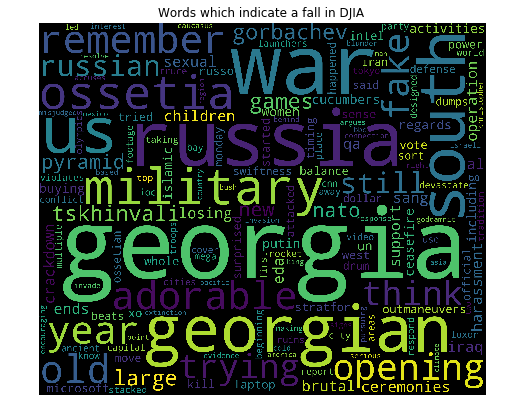

In [72]:
wordcloud1 = WordCloud(background_color='black',
                      width=3000,
                      height=2500
                     ).generate(decrease_word[1])
plt.figure(1,figsize=(8,8))
plt.imshow(wordcloud1)
plt.axis('off')
plt.title("Words which indicate a fall in DJIA ")
plt.show()

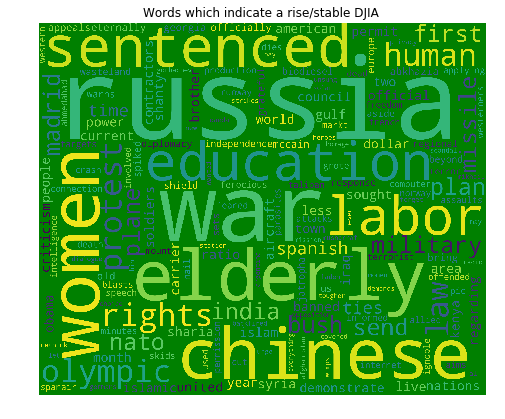

In [73]:
wordcloud2 = WordCloud(background_color='green',
                      width=3000,
                      height=2500
                     ).generate(non_decrease_word[3])
plt.figure(1,figsize=(8,8))
plt.imshow(wordcloud2)
plt.axis('off')
plt.title("Words which indicate a rise/stable DJIA ")
plt.show()

## Text Preprocessing

In [13]:
example = train.iloc[3,3]
print(example)

b"When the president ordered to attack Tskhinvali [the capital of South Ossetia], we knew then we were doomed. How come he didn't realize that?"


##### Lower Case

In [14]:
example2 = example.lower()
print(example2)

b"when the president ordered to attack tskhinvali [the capital of south ossetia], we knew then we were doomed. how come he didn't realize that?"


##### Count Vectorizer

In [15]:
example3 = CountVectorizer().build_tokenizer()(example2)
print(example3)

['when', 'the', 'president', 'ordered', 'to', 'attack', 'tskhinvali', 'the', 'capital', 'of', 'south', 'ossetia', 'we', 'knew', 'then', 'we', 'were', 'doomed', 'how', 'come', 'he', 'didn', 'realize', 'that']


In [16]:
pd.DataFrame([[x,example3.count(x)] for x in set(example3)], columns = ['Word', 'Count'])

,Word,Count
0,president,1
1,we,2
2,south,1
3,capital,1
4,of,1
5,the,2
6,to,1
7,then,1
8,ordered,1
9,doomed,1


The process involved:

- Converting the headline to lowercase letters
- Splitting the sentence into a list of words
- Removing punctuation and meaningless words


### Basic Model Training and Testing

The tool we'll be using is CountVectorizer, which takes a single list of strings as input, and produces word counts for each one.

In [17]:
basicvectorizer = CountVectorizer()
basictrain = basicvectorizer.fit_transform(trainheadlines)
print(basictrain.shape)

(1611, 31675)


In [18]:
testheadlines = []
for row in range(0,len(test.index)):
    testheadlines.append(' '.join(str(x) for x in test.iloc[row,2:27]))


In [19]:
basictest = basicvectorizer.transform(testheadlines)
print(basictest.shape)

(378, 31675)


Our resulting table contains counts for 31,675 different words!

**Model Fitting**

In [32]:
Classifiers = [
    LogisticRegression(C=0.1,solver='liblinear',max_iter=2000),
    KNeighborsClassifier(3),
    RandomForestClassifier(n_estimators=500,max_depth=9),
    ]

In [21]:
Accuracy=[]
Model=[]
for classifier in Classifiers:
    try:
        fit = classifier.fit(basictrain,train['Label'])
        pred = fit.predict(basictest)
        prob = fit.predict_proba(basictest)[:,1]
    except Exception:
        fit = classifier.fit(basictrain,train['Label'])
        pred = fit.predict(basictest)
        prob = fit.predict_proba(basictest)[:,1]
    accuracy = accuracy_score(pred,test['Label'])
    Accuracy.append(accuracy)
    Model.append(classifier.__class__.__name__)
    fpr, tpr, _ = roc_curve(test['Label'],prob)

In [29]:
df=pd.DataFrame(columns = ['Model', 'Accuracy'],index=np.arange(1, len(df)+1))
df.Model=Model
df.Accuracy=Accuracy
df

,Model,Accuracy
1,LogisticRegression,0.431217
2,KNeighborsClassifier,0.510582
3,RandomForestClassifier,0.507937


### Feature Extraction

**TFIDF Model**


Lets try to improve the score with more models and feature Selection.

In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf=TfidfVectorizer()
train_text = []
test_text = []
for each in train['Combined']:
    train_text.append(to_words(each))

for each in test['Combined']:
    test_text.append(to_words(each))
train_features = tfidf.fit_transform(train_text)
test_features = tfidf.transform(test_text)

## Model fitting

In [46]:
Classifiers = [
    LogisticRegression(C=0.1,solver='liblinear',max_iter=2000),
    KNeighborsClassifier(3),
    SVC(kernel="rbf", C=0.25, probability=True),
    DecisionTreeClassifier(),
    RandomForestClassifier(n_estimators=500,max_depth=9),
    AdaBoostClassifier(),
    ]

In [57]:
dense_features=train_features.toarray()
dense_test= test_features.toarray()
Accuracy=[]
Model=[]
for classifier in Classifiers:
    try:
        fit = classifier.fit(train_features,train['Label'])
        pred = fit.predict(test_features)
        prob = fit.predict_proba(test_features)[:,1]
    except Exception:
        fit = classifier.fit(dense_features,train['Label'])
        pred = fit.predict(dense_test)
        prob = fit.predict_proba(dense_test)[:,1]
    accuracy = accuracy_score(pred,test['Label'])
    Accuracy.append(accuracy)
    Model.append(classifier.__class__.__name__)
    fpr, tpr, _ = roc_curve(test['Label'],prob)
    

/opt/conda/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [60]:
df=pd.DataFrame(columns = ['Model', 'Accuracy'],index=np.arange(1, len(df)+1))
df.Model=Model
df.Accuracy=Accuracy
df

,Model,Accuracy
1,LogisticRegression,0.468254
2,KNeighborsClassifier,0.484127
3,SVC,0.500000
4,DecisionTreeClassifier,0.507937
5,RandomForestClassifier,0.507937
6,AdaBoostClassifier,0.507937


As we can see, there has been a slight improvement from the previous scores.

## Advanced Modeling

The technique we just used is known as a **bag-of-words** model. We essentially placed all of our headlines into a "bag" and counted the words as we pulled them out.

However,  a single word doesn't always have enough meaning by itself.

We need to consider the rest of the words in the sentence as well!

### N - gram model

##### n=2

In [64]:
advancedvectorizer = CountVectorizer(ngram_range=(2,2))
advancedtrain = advancedvectorizer.fit_transform(trainheadlines)
print(advancedtrain.shape)


(1611, 366721)


This time we have 366,721 unique variables representing two-word combinations!

In [50]:
advancedtest = advancedvectorizer.transform(testheadlines)

In [51]:
Accuracy=[]
Model=[]
for classifier in Classifiers:
    try:
        fit = classifier.fit(advancedtrain,train['Label'])
        pred = fit.predict(advancedtest)
        prob = fit.predict_proba(advancedtest)[:,1]
    except Exception:
        fit = classifier.fit(advancedtrain,train['Label'])
        pred = fit.predict(advancedtest)
        prob = fit.predict_proba(advancedtest)[:,1]
    accuracy = accuracy_score(pred,test['Label'])
    Accuracy.append(accuracy)
    Model.append(classifier.__class__.__name__)
    fpr, tpr, _ = roc_curve(test['Label'],prob)
    

/opt/conda/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [54]:
df=pd.DataFrame(columns = ['Model', 'Accuracy'],index=np.arange(1, len(df)+1))
df.Model=Model
df.Accuracy=Accuracy
df

,Model,Accuracy
1,LogisticRegression,0.500000
2,KNeighborsClassifier,0.507937
3,SVC,0.507937
4,DecisionTreeClassifier,0.507937
5,RandomForestClassifier,0.513228
6,AdaBoostClassifier,0.560847


We are getting much better results now and we are getting an accuracy of 56.08%.

##### n=3

In [71]:
advancedvectorizer = CountVectorizer(ngram_range=(3,3))
advancedtrain = advancedvectorizer.fit_transform(trainheadlines)
print(advancedtrain.shape)
advancedtest = advancedvectorizer.transform(testheadlines)

(1611, 611140)


This time we have 611,140 unique variables representing three-word combinations!

In [68]:
Accuracy=[]
Model=[]
for classifier in Classifiers:
    try:
        fit = classifier.fit(advancedtrain,train['Label'])
        pred = fit.predict(advancedtest)
        prob = fit.predict_proba(advancedtest)[:,1]
    except Exception:
        fit = classifier.fit(advancedtrain,train['Label'])
        pred = fit.predict(advancedtest)
        prob = fit.predict_proba(advancedtest)[:,1]
    accuracy = accuracy_score(pred,test['Label'])
    Accuracy.append(accuracy)
    Model.append(classifier.__class__.__name__)
    fpr, tpr, _ = roc_curve(test['Label'],prob)

/opt/conda/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [70]:
df=pd.DataFrame(columns = ['Model', 'Accuracy'],index=np.arange(1, len(df)+1))
df.Model=Model
df.Accuracy=Accuracy
df

,Model,Accuracy
1,LogisticRegression,0.500000
2,KNeighborsClassifier,0.507937
3,SVC,0.507937
4,DecisionTreeClassifier,0.507937
5,RandomForestClassifier,0.507937
6,AdaBoostClassifier,0.513228


The accuracy does not seem to increase and it looks like we have hit our maximum accuracy point at 56%.